<a href="https://colab.research.google.com/github/lisya/ML_in_business/blob/lesson05/dz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Notebooks/ML_in_business/5/materials5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['RowNumber','CustomerId','Surname']), df['Exited'], random_state=0)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2967,579,Germany,Female,39,5,117833.30,3,0,0,5831.00,1
700,750,France,Female,32,5,0.00,2,1,0,95611.47,0
3481,729,Spain,Female,34,9,53299.96,2,1,1,42855.97,0


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


### Oбучим модель с помощью Catboost

In [9]:
!pip install catboost

     |████████████████████████████████| 65.7MB 55kB/s 


In [10]:
from catboost import CatBoostClassifier

In [11]:
catm = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
catm.fit(X_train, y_train, cat_features=categorical_columns)


In [12]:
#наши прогнозы для тестовой выборки
preds = catm.predict_proba(X_test)[:, 1]
preds[:10]

array([4.10986893e-04, 9.98022577e-01, 3.57590326e-04, 5.79593290e-04,
       3.97088130e-04, 9.98104513e-01, 5.67615381e-04, 4.11677247e-04,
       9.96795538e-01, 9.77391801e-01])

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, plot_precision_recall_curve, classification_report, precision_recall_curve, confusion_matrix

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.909561, F-Score=1.000, Precision=1.000, Recall=1.000


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1991    0]
 [   1  508]]


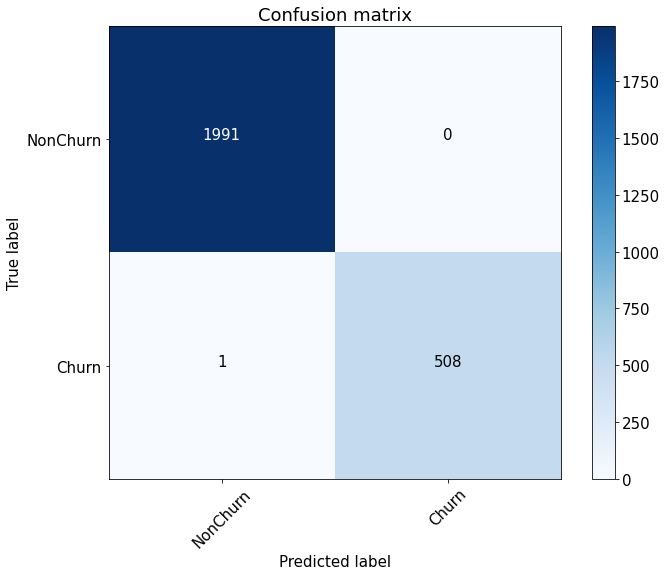

In [16]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


**Как—то идеально модель предсказала таргет. Это вообще реально?**

## Логистическая регрессия

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [19]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [20]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(max_iter=1000,random_state = 42)),
])

In [21]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [22]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [23]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


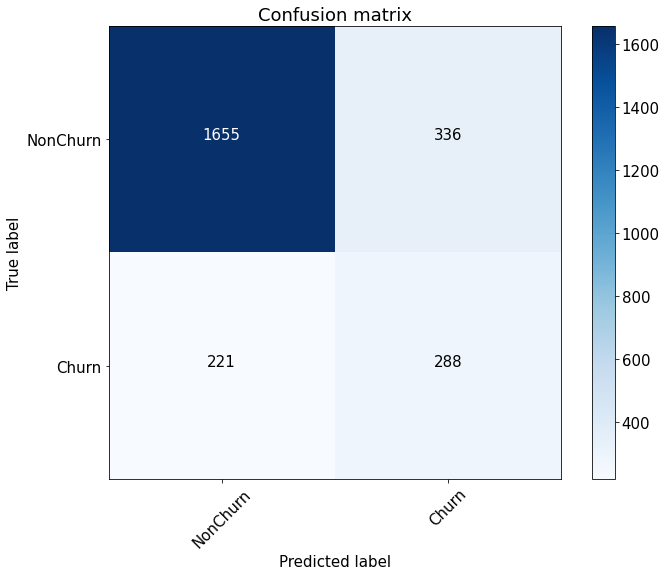

In [25]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Я не очень понял как правильно считать экономическую эффективность.


Каждый клиент приносит 2 доллара. Если клиент собирается уйти то нужно потратить 1 доллар чтобы он вернулся.


Попробую посчитать эффективность на модели логистической регрессии.


Итак модель нам предсказала 1876 элемент как 1, т.е. NonChurn. Из них 1655 предсказала верно(TP) и 221 неверно(TN). 
TP принесут нам по 2 доллара за клиента => 1655 * 2 == **3310**

FP это те клиенты, которых мы посчитали, что они не уйдут, не стали тратить на их удержание деньги, но клиенты ушли => мы не получили с клиентов прибыли по 2 доллара, но и не потратили на их удержание по 1 доллару. **Прибыль 0**.

Теперь у нас 624 значений модель определила как 0, то есть Churn.
На всех 624 клиентов нам нужно потратить по 1 доллару.

Но 336(FN) клиентов на самом деле приносят нам по 2 доллара, потому что модель их неправильно определила и мы также тратим на них 1 доллар на неправильное удержание, итого они принесут нам **+168 долларов**.

288 TN - тратим на удержание 1 доллар,но в итоге после того как мы их удержим, они принесут 2 доллара прибыли, **итого +144 доллара.**

Следовательно с удержанием мы получим прибыль в итоге **3310+168+144 = 3662**

Если бы мы не стали тратиться на удержание то прибыль была бы **1655*2 + 336*2 = 3310+672 = 3982**

Поэтому на данной модели при таких условиях прибилы клиента и цены удержания, не выгодно удерживать клиента.



**Может быть я не так понял принцип расчета экономической эффективности.**